In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
# --------------------- #
# Step 1: Load the data #
# --------------------- #
df = pd.read_excel("MasterDataset_ML - old 2.xlsx")

In [18]:
# --------------------------------------------------------------------- #
# Step 1.1: Remove referees that have a count less than a certain value #
# --------------------------------------------------------------------- #
counts = df['Referee'].value_counts()
rare_refs = counts[counts < 70].index
df = df[~df['Referee'].isin(rare_refs)]

# ----------------------------------- #
# Step 2: Define targets and features #
# ----------------------------------- #
TargetReferee = False
Target = "Referee" if TargetReferee == True else "WIN"
Feature = 'Referee' if Target == 'WIN' else 'WIN'
print(Target, Feature)

# --------------------------------------------------------------- #
# Step 2.1: If Target = "WIN", then remove the goal score columns #
# --------------------------------------------------------------- #
if (Target=="WIN"):
    df = df.drop('H_Score', axis=1)
    df = df.drop('A_Score', axis=1)

df = df.drop(['Stadium Capacity', 'MatchId'], axis=1) # Might not need this but keep for now..

y = df[Target] 
x = df.drop(Target, axis=1)

WIN Referee


In [19]:
# ------------------------------- # 
# Step 3: Label encode the target # 
# ------------------------------- # 
le = LabelEncoder() 
y_encoded = le.fit_transform(y)

In [20]:
# ---------------------------------------------- # 
# Step 4: One hot encode key categorical columns # 
# ---------------------------------------------- # 
categorial_columns = ["Home", "Away", "Stadium City", "Referee - UK Region of Birth", "Season Start Year", Feature] 
x_encoded = pd.get_dummies(x, columns=categorial_columns, drop_first=True)

In [21]:
# ------------------------- #
# Step 5: Imputer & Scaling #
# ------------------------- #
Simple = True

# -------------- #
# SIMPLE IMPUTER #
# -------------- #
if (Simple):
    # IMPUTE
    imputer = SimpleImputer(strategy='mean')
    x_imputed = pd.DataFrame(imputer.fit_transform(x_encoded), columns=x_encoded.columns)

    # SCALE
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x_imputed)
    
# ----------- #
# KNN IMPUTER #
# ----------- #
else :
    # SCALE
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x_encoded)
    x_scaled_df = pd.DataFrame(x_scaled, columns=x_encoded.columns)

    # IMPUTE
    imputer = KNNImputer(n_neighbors=5, weights="distance")
    x_imputed = pd.DataFrame(imputer.fit_transform(x_scaled_df), columns=x_scaled_df.columns)

# The x value that goes into train_test_split
TTS_xValue = x_scaled if Simple == True else x_imputed

In [22]:
# ------------------------ #
# Step 6: Split train/test #
# ------------------------ #
x_train, x_test, y_train, y_test = train_test_split(
    TTS_xValue, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [23]:
# --------------------------- #
# Step 7: Train Random Forest #
# --------------------------- #
if Target == "Referee":
    rf = RandomForestClassifier(class_weight="balanced", max_depth= 20, min_samples_leaf= 4, min_samples_split= 2, n_estimators= 200, random_state=42)

# --------------------------------------------------- #
# If the target was which side won [home, away, draw] #
# --------------------------------------------------- #
else:
    weights = {
        0: 1.1,
        1: 1.4,
        2: 0.7,
    }
    rf = RandomForestClassifier(class_weight=weights, max_depth= 30, min_samples_leaf= 4, min_samples_split= 10, n_estimators= 300, random_state=42)

rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

In [24]:
# ----------------------------- #
# Step 8 - Evaluate Performance #
# ----------------------------- #
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy:  0.4954710144927536
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.62      0.53       336
           1       0.33      0.27      0.29       268
           2       0.61      0.53      0.57       500

    accuracy                           0.50      1104
   macro avg       0.47      0.47      0.47      1104
weighted avg       0.50      0.50      0.49      1104



In [25]:
# -------------------------------------------- #
# Step 9 - Feature Importance (Detection Bias) #
# -------------------------------------------- #
importances = rf.feature_importances_
features = x_encoded.columns

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by="Importance", ascending=False)

print("\nTop 30 Most Influential Features:")
print(importance_df.head(30))

# -------------------------------- #
# Confederation Feature Importance #
# -------------------------------- #
federation_importance = importance_df[importance_df['Feature'].str.contains("AFC|CAF|UEFA|CONMEBOL|CONCACAF|OFC")]
print("\nFederation Feature Importance")
print(federation_importance)

grouped_importance = importance_df.groupby(
    importance_df['Feature'].apply(
        lambda x: 'Federation' if any(f in x for f in ["AFC", "CAF", "UEFA", "CONMEBOL", "CONCACAF", "OFC"])
        else 'RefereeBirthCity' if 'Referee - UK Region of Birth' in x
        else 'MatchStats'
    )
)['Importance'].sum()
print("\nGrouped Feature Importances:")
print(grouped_importance)


Top 30 Most Influential Features:
                                Feature  Importance
0                    Stadium Attendance    0.075079
8                     A_Ball_Possession    0.053113
7                     H_Ball_Possession    0.052782
14                              A_Fouls    0.043171
9                          H_Free_Kicks    0.042547
13                              H_Fouls    0.040515
15                       H_Yellow_Cards    0.039792
10                         A_Free_Kicks    0.038567
12                       A_Corner_Kicks    0.038561
11                       H_Corner_Kicks    0.037391
16                       A_Yellow_Cards    0.033215
6                         Region - UEFA    0.028003
118             Stadium City_Manchester    0.021907
3                     Region - CONMEBOL    0.016137
2                          Region - CAF    0.016104
82                 Away_Manchester City    0.015514
41                 Home_Manchester City    0.015039
116                 Stadium C

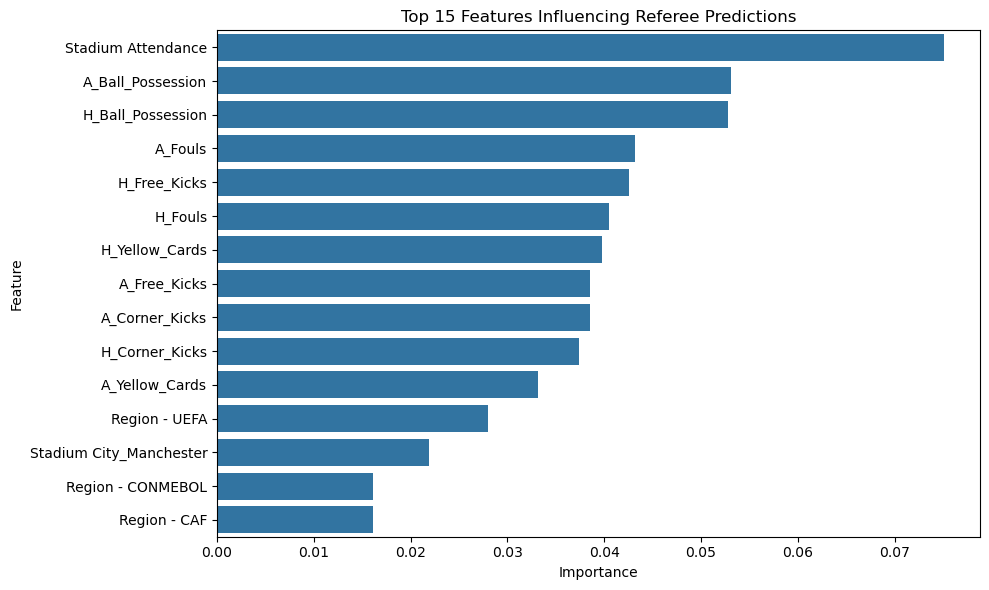

In [26]:
# ----------------------- #
# Step 10 - Visualize it! #
# ----------------------- #
plt.figure(figsize=(10,6))
sns.barplot(data=importance_df.head(15), x='Importance', y='Feature')
plt.title('Top 15 Features Influencing Referee Predictions')
plt.tight_layout()
plt.show()

In [ ]:
# ------------------------ #
# Step 3: Train/Test Split #
# ------------------------ #
x_train, x_test, y_train, y_test = train_test_split(
    df.drop('Referee', axis=1),
    df['Referee'],
    test_size=0.2,
    random_state=42,
    stratify=df['Referee']
)

In [ ]:
# -------------------------------- #
# Step 4: Compute Referee Averages #
# -------------------------------- #
train_df = x_train.copy()
train_df['Referee'] = y_train

ref_stats_train = train_df.groupby('Referee').agg({
    'Total_Yellow_Cards': 'mean',
    'Total_Red_Cards': 'mean',
    'Total_Fouls': 'mean',
    'PenaltiesAwarded': 'mean',
    # 'MatchId': 'count',
# }).rename(columns={'MatchId': 'matches_officiated'})
})

ref_stats_train['diciplinary_index'] = (
    ref_stats_train['Total_Yellow_Cards'] 
    + 2 * ref_stats_train['Total_Red_Cards'] 
    + 0.5 * ref_stats_train['PenaltiesAwarded']
)

# Merge these averages into both splits
x_train = x_train.copy()
x_test = x_test.copy()
x_train['Referee'] = y_train
x_test['Referee'] = y_test

# Merge based on that temporary column
x_train = x_train.merge(ref_stats_train, left_on='Referee', right_index=True, how='left')
x_test = x_test.merge(ref_stats_train, left_on='Referee', right_index=True, how='left')
x_test.fillna(ref_stats_train.mean(), inplace=True)
# print(x_train)

# Drop the Referee column again + matchId
x_train = x_train.drop(columns=['Referee'])
x_train = x_train.drop(columns=['MatchId'])
x_test = x_test.drop(columns=['Referee'])
x_test = x_test.drop(columns=['MatchId'])

In [ ]:
# -------------------------- #
# Step 5: Encode the target  #
# -------------------------- #
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [ ]:
# -------------------------------------------- #
# Step 6: One-hot encode categorical features  #
# -------------------------------------------- #
categorical_columns = [
    "Home", "Away", "Stadium City",
    "Referee - UK Region of Birth", "Season Start Year", Feature
]

# Fit encoder only on training data
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder.fit(x_train[categorical_columns])

# Transform both sets
x_train_encoded = pd.DataFrame(
    encoder.transform(x_train[categorical_columns]),
    columns=encoder.get_feature_names_out(categorical_columns),
    index=x_train.index
)
x_test_encoded = pd.DataFrame(
    encoder.transform(x_test[categorical_columns]),
    columns=encoder.get_feature_names_out(categorical_columns),
    index=x_test.index
)

# Merge back encoded + numeric columns
x_train = pd.concat([x_train.drop(columns=categorical_columns), x_train_encoded], axis=1)
x_test = pd.concat([x_test.drop(columns=categorical_columns), x_test_encoded], axis=1)

In [ ]:
# ------------------------- #
# Step 7: Impute & Scale    #
# ------------------------- #
Simple = True

if Simple:
    imputer = SimpleImputer(strategy='mean')
    x_train_imputed = pd.DataFrame(imputer.fit_transform(x_train), columns=x_train.columns, index=x_train.index)
    x_test_imputed = pd.DataFrame(imputer.transform(x_test), columns=x_test.columns, index=x_test.index)

    scaler = StandardScaler()
    x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train_imputed), columns=x_train.columns, index=x_train.index)
    x_test_scaled = pd.DataFrame(scaler.transform(x_test_imputed), columns=x_test.columns, index=x_test.index)
else:
    scaler = StandardScaler()
    x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns, index=x_train.index)
    x_test_scaled = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns, index=x_test.index)

    imputer = KNNImputer(n_neighbors=5, weights="distance")
    x_train_scaled = pd.DataFrame(imputer.fit_transform(x_train_scaled), columns=x_train.columns, index=x_train.index)
    x_test_scaled = pd.DataFrame(imputer.transform(x_test_scaled), columns=x_test.columns, index=x_test.index)

In [ ]:
# --------------------------- #
# Step 8: Train Random Forest #
# --------------------------- #
if Target == "Referee":
    rf = RandomForestClassifier(
        class_weight="balanced",
        max_depth=20,
        min_samples_leaf=4,
        min_samples_split=2,
        n_estimators=200,
        random_state=42
    )
else:
    weights = {0: 1.1, 1: 1.4, 2: 0.7}
    rf = RandomForestClassifier(
        class_weight=weights,
        max_depth=30,
        min_samples_leaf=4,
        min_samples_split=10,
        n_estimators=300,
        random_state=42
    )

rf.fit(x_train_scaled, y_train_encoded)
y_pred = rf.predict(x_test_scaled)

In [ ]:
# # ------------------- #
# # Step 8: ParamGrid ! #
# # ------------------- #
# rf = RandomForestClassifier(random_state=42)
# param_grid = {
#     'n_estimators': [100,200,300],
#     'max_depth': [None, 10,20,30],
#     'min_samples_split': [2,5,10],
#     'min_samples_leaf': [1,2,4],
#     'class_weight': [None, 'balanced']
# }

# grid_search = GridSearchCV(
#     estimator = rf,
#     param_grid = param_grid,
#     cv = 3,
#     n_jobs = -1,
#     verbose = 2
# )

# grid_search.fit(x_train, y_train)
# print("Best Parameters: ", grid_search.best_params_)
# print("Best Accuracy: ", grid_search.best_score_)

# best_rf = grid_search.best_estimator_
# y_pred = best_rf.predict(x_test)
# print("Test Accuracy:", accuracy_score(y_test, y_pred))

# rf.fit(x_train, y_train)

In [89]:
# -------------------------- #
# Step 12 - Multiple Models! #
# -------------------------- #
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000), # Add regularization to the parameters
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(max_depth= 20, min_samples_leaf= 4, min_samples_split= 2, n_estimators= 200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(n_neighbors=20) # Adjust, make this smaller depending
}

results = []

for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    results.append({"Model": name, "Accuracy": acc})
    print(f"\n{name}")
    print("Accuracy:", acc)
    print(classification_report(y_test, y_pred, zero_division=0))

results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)
print("\nModel Comparison:")
print(results_df)


Logistic Regression
Accuracy: 0.509963768115942
              precision    recall  f1-score   support

           0       0.50      0.56      0.53       336
           1       0.27      0.09      0.14       268
           2       0.55      0.70      0.62       500

    accuracy                           0.51      1104
   macro avg       0.44      0.45      0.43      1104
weighted avg       0.47      0.51      0.47      1104


Decision Tree
Accuracy: 0.4302536231884058
              precision    recall  f1-score   support

           0       0.44      0.42      0.43       336
           1       0.28      0.31      0.30       268
           2       0.51      0.50      0.51       500

    accuracy                           0.43      1104
   macro avg       0.41      0.41      0.41      1104
weighted avg       0.43      0.43      0.43      1104


Random Forest
Accuracy: 0.5335144927536232
              precision    recall  f1-score   support

           0       0.53      0.52      0.52   

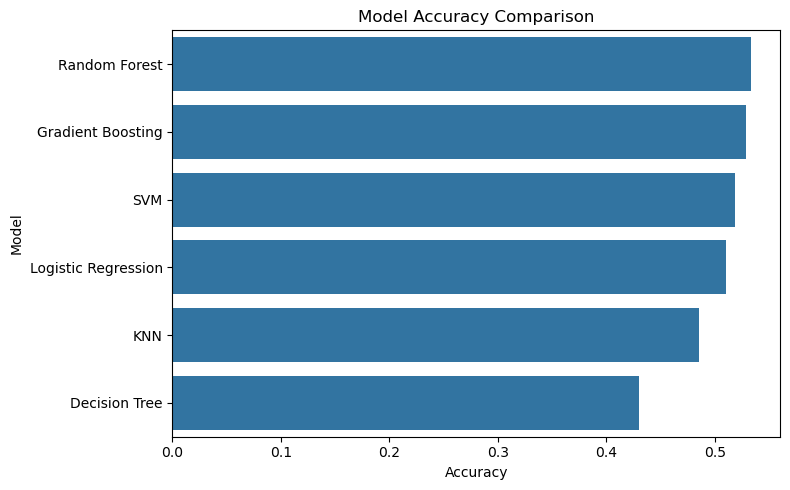

In [90]:
# -------------------------- #
# Visualize multiple models! #
# -------------------------- #

plt.figure(figsize=(8,5))
sns.barplot(data=results_df, x="Accuracy", y="Model")
plt.title("Model Accuracy Comparison")
plt.tight_layout()
plt.show()